# NLP II - Práctica 2

**Clasificación biclase de Reviews (positivo/negativo)**

---

### Tabla de contenidos
1.  [Librerias necesarias](#1-setup)
2.  [Extracción, Armonización e Importación de los datos](#2-data)
3.  [Transformer Practica 1 (P1)](#3-teacher)
4.  [Modulo Retrieval Denso](#41-retrieval)
5.  [Clasificador k-NN](#42-knn)
6.  [Transformer Híbrido+ k-NN (RAG)](#43-hybrid)
7.  [Explicabilidad](#44-explainability)
8.  [Compresión y destilación](#45-compression)
9.  [Generador de Resumenes](#46-summarization)
10. [Análisis global](#47-analysis)

---
## 1. Librerias Necesarias <a id="1-setup"></a>

In [5]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {DEVICE}")

PyTorch version: 2.9.1+cu130
CUDA available: True
GPU: NVIDIA GeForce RTX 5070 Laptop GPU

Using device: cuda


In [6]:
from src.data_loader import DataLoader
from src.text_preprocessor import TextPreprocessor
from src.embedding_extractor import EmbeddingExtractor
from src.dense_retriever import DenseRetriever
from src.knn_classifier import KNNClassifier
from src.hybrid_classifier import HybridClassifier
from src.model_trainer import ModelTrainer
from src.compressor import ModelCompressor
from src.summarizer import SummarizationExplainer
from src.explainability import ExplainabilityModule
from src.evaluator import Evaluator

---
## 2. Extracción, Armonización e Importación de los datos <a id="2-data"></a>

In [10]:
data_loader = DataLoader(text_column="text", label_column="label", random_state=42)

data_loader.download_data(save=True)

train_df, val_df, test_df = data_loader.load_data(
    val_size=0.1,
    test_size=0.1
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 200800
Validation samples: 25100
Test samples: 25100


In [11]:
# Stats de los datos
data_stats = data_loader.get_data_stats()
for key, value in data_stats.items():
    print(f"{key}: {value}")

total_samples: 251000
num_classes: 2
class_distribution: {0: 125677, 1: 125323}
avg_text_length: 604.180984063745
min_text_length: 11
max_text_length: 13704


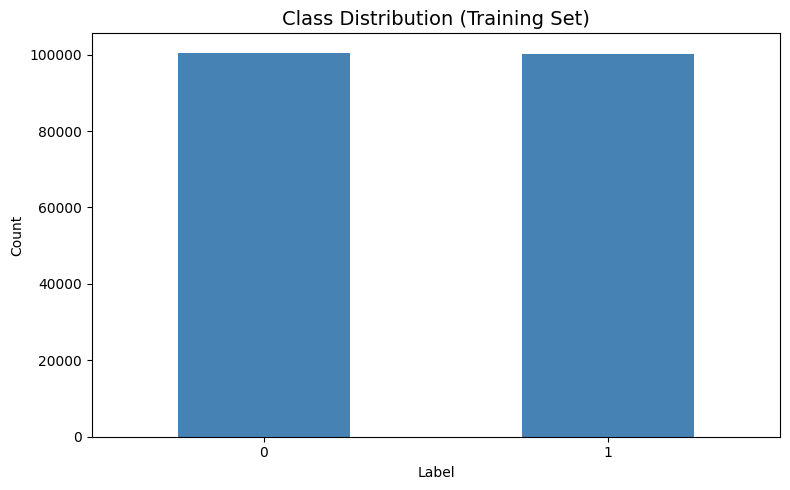

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
train_df['label'].value_counts().plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Class Distribution (Training Set)', fontsize=14)
ax.set_xlabel('Label')
ax.set_ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [13]:
train_texts = train_df['text'].tolist()
train_labels = train_df['label_encoded'].tolist()
train_labels_raw = train_df['label'].tolist()

val_texts = val_df['text'].tolist()
val_labels = val_df['label_encoded'].tolist()

test_texts = test_df['text'].tolist()
test_labels = test_df['label_encoded'].tolist()
test_labels_raw = test_df['label'].tolist()

label_names = data_loader.get_label_names()
num_labels = data_loader.get_num_labels()

print(f"\nLabels names: {label_names}")
print(f"Number of classes: {num_labels}")


Labels names: [np.int64(0), np.int64(1)]
Number of classes: 2


---
## 3. Transformer Practica 1 (P1) <a id="3-teacher"></a>


In [14]:
PRACTICE_1_MODEL_NAME = "roberta-base"
PRACTICE_1_MODEL_SAVE_PATH = "models/previous_model"

if os.path.exists(PRACTICE_1_MODEL_SAVE_PATH):
    print(f"El path existe: {PRACTICE_1_MODEL_SAVE_PATH}")

else:
    print(f"El path no existe: {PRACTICE_1_MODEL_SAVE_PATH}")

practice_1_model = ModelTrainer(
    model_name=PRACTICE_1_MODEL_NAME,
    num_labels=num_labels,
    device=DEVICE,
    label_names=label_names
)

print(f"\nPractice 1 transformer model: {PRACTICE_1_MODEL_NAME}")
print(f"\nNumber of parameters: {sum(p.numel() for p in practice_1_model.model.parameters()):,}")

El path existe: models/previous_model


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Practice 1 transformer model: roberta-base

Number of parameters: 124,647,170


In [15]:
preprocessor = TextPreprocessor(model_name=PRACTICE_1_MODEL_NAME, max_length=256)

train_dataset = preprocessor.prepare_dataset(train_texts, train_labels)
val_dataset = preprocessor.prepare_dataset(val_texts, val_labels)
test_dataset = preprocessor.prepare_dataset(test_texts, test_labels)

print(f"\n Prepared datasets:")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")


 Prepared datasets:
  Train: 200800 samples
  Val: 25100 samples
  Test: 25100 samples


In [16]:
TRAIN_PREVIOUS_MODEL = False #Set Tue if you want to retrain de model

if TRAIN_PREVIOUS_MODEL:
    print("Training Practice 1 Model...")
    history = practice_1_model.train(
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        epochs=1,
        batch_size=32,
        learning_rate=2e-5,
        save_best=True,
        save_path=PRACTICE_1_MODEL_SAVE_PATH
    )
else:
    print("Loading Practice 1 Model...")
    practice_1_model.load_model(PRACTICE_1_MODEL_SAVE_PATH)
    history = practice_1_model.history

Loading Practice 1 Model...
Model loaded from models/previous_model


In [10]:
print("\nPractice 1 Model Evaluation:")
practice_1_model_metrics = practice_1_model.evaluate(test_dataset)

for metric, value in practice_1_model_metrics.items():
    print(f"  {metric}: {value:.4f}")


Practice 1 Model Evaluation:


Evaluating: 100%|██████████| 785/785 [02:15<00:00,  5.79it/s]


  test_loss: 0.1081
  test_accuracy: 0.9640
  test_macro_f1: 0.9640


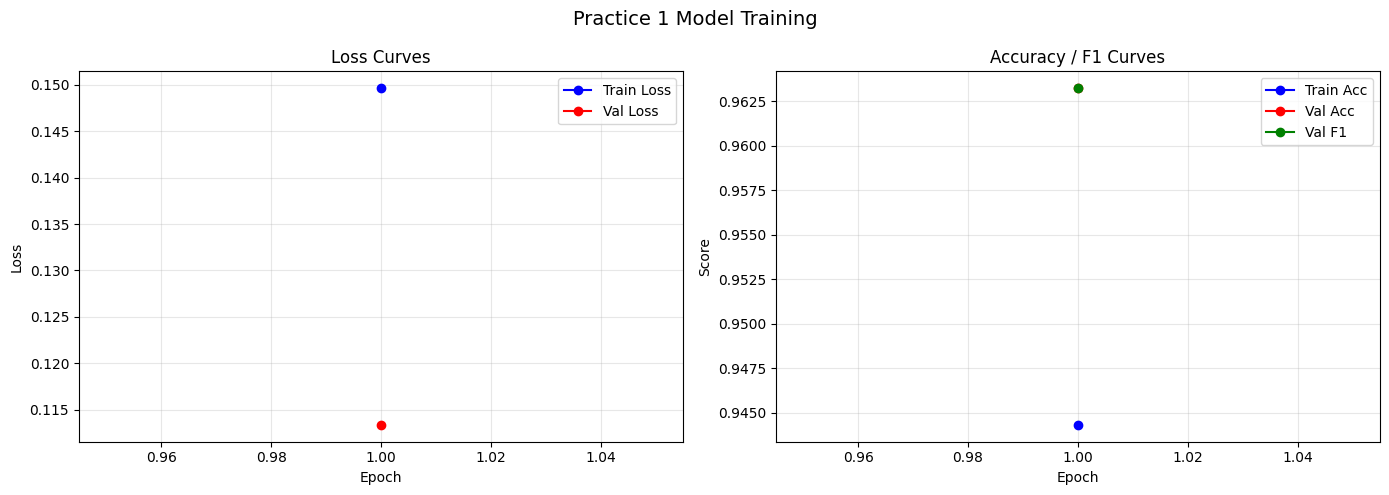

In [11]:
if history.get('train_loss'):
    evaluator = Evaluator(label_names=label_names)
    fig = evaluator.plot_training_curves(history, title="Practice 1 Model Training")
    plt.show()

else:
    print("No training history available.")

In [12]:
previous_model_preds, previous_model_probs = practice_1_model.predict(test_texts)
print(f"Practice 1 model predictions shape: {previous_model_preds.shape}")
print(f"Practice 1 model probabilities shape: {previous_model_probs.shape}")

Practice 1 model predictions shape: (25100,)
Practice 1 model probabilities shape: (25100, 2)


---
## 4.1 Modulo Retrieval Denso <a id="41-retrieval"></a>

In [13]:
embedding_extractor = EmbeddingExtractor(
    model_name_or_model=practice_1_model.model.roberta,
    tokenizer=practice_1_model.tokenizer,
    device=DEVICE,
    pooling_strategy="cls"
)

print(f"Embedding dimension: {embedding_extractor.get_embedding_dimension()}")

Embedding dimension: 768


In [14]:
retriever = DenseRetriever(
    embedding_extractor=embedding_extractor,
    metric="cosine"
)

print("\n Building retrieval index...")
retriever.build_index(train_texts, train_labels_raw)

print("\n Index Statistics:")
for key, value in retriever.get_corpus_stats().items():
    print(f"{key}: {value}")


 Building retrieval index...
Generating embeddings for 200800 texts...


Extracting embeddings: 100%|██████████| 6275/6275 [38:07<00:00,  2.74it/s]


Index built with 200800 documents.

 Index Statistics:
num_documents: 200800
embedding_dim: 768
num_labels: 2
label_distribution: {0: 100541, 1: 100259}
metric: cosine


In [15]:
sample_query = test_texts[0]
print(f"Query: {sample_query[:200]}...")
print(f"True label: {test_labels_raw[0]}")

results = retriever.search([sample_query], k=5)

print(f"\n Top-5 Similar Training Examples:")
for i, (text, label, dist) in enumerate(zip(results[0].texts, results[0].labels, results[0].distances), 1):
    print(f"\n  [{i}] Label: {label} | Distance: {dist:.4f}")
    print(f"      {text[:100]}...")

Query: Left Cold I found "Snow Flower and the Secret Fan `to be lacking in human emotions. There were many areas in the story that I wanted more compassion from Lilly. She was cold even during the most emoti...
True label: 0

 Top-5 Similar Training Examples:

  [1] Label: 0 | Distance: 0.0306
      He has written such better books To me, Doug Allyn is one of the many underrated authors. I have enj...

  [2] Label: 0 | Distance: 0.0340
      Not As Moving I'm guilty, I love Nicholas Sparks' books, particularly The Notebook. I don't believe ...

  [3] Label: 0 | Distance: 0.0341
      Just Misery...Know Sula, No Peace... SULA, I don't know why folks have been saying this book was har...

  [4] Label: 1 | Distance: 0.0351
      Abrupt End I've enjoyed other books by McCullough but was disappointed in this one. Just after descr...

  [5] Label: 0 | Distance: 0.0359
      Another first: this French movie is my introduction to the world Eric Rohmer. Perhaps I'm a bit hast...


In [16]:
print("\n Evaluating Retrieval Quality...")
retrieval_metrics = retriever.evaluate_retrieval(
    test_texts[:200],
    test_labels_raw[:200],
    k_values=[1, 3, 5, 10]
)

print("\n Retrieval Metrics:")
for k, metrics in retrieval_metrics.items():
    print(f"  {k}:")
    for metric, value in metrics.items():
        print(f"    {metric}: {value:.4f}")


 Evaluating Retrieval Quality...

 Retrieval Metrics:
  k=1:
    precision@k: 0.9600
    recall@k: 0.9600
  k=3:
    precision@k: 0.9583
    recall@k: 0.9850
  k=5:
    precision@k: 0.9580
    recall@k: 0.9850
  k=10:
    precision@k: 0.9615
    recall@k: 0.9900


### Analisis de la implementacion de KNN

In [17]:
from collections import defaultdict

per_class_precision = defaultdict(list)
sample_size = min(200, len(test_texts))

for i in range(sample_size):
    results = retriever.search([test_texts[i]], k=5)
    true_label = test_labels_raw[i]
    matching = sum(1 for l in results[0].labels if l == true_label)
    per_class_precision[true_label].append(matching / 5)

print("\n Per-Class Precision@5:")
for label, precisions in sorted(per_class_precision.items()):
    avg_precision = np.mean(precisions)
    print(f"  {label}: {avg_precision:.4f} (n={len(precisions)})")


 Per-Class Precision@5:
  0: 0.9593 (n=113)
  1: 0.9563 (n=87)


---
## 4.2 Clasificadork-NN <a id="42-knn"></a>

Clasificador de nuevos textos basado en la vecindad de documentos similares.


In [18]:
knn_classifier = KNNClassifier(
    retriever=retriever,
    k=5,
    num_classes=num_labels,
    weighted=False
)

print("k-NN Classifier initialized:")
print(f"  {knn_classifier.get_params()}")

k-NN Classifier initialized:
  {'k': 5, 'num_classes': 2, 'weighted': False, 'metric': 'cosine'}


In [19]:
print("\n Making k-NN predictions...")
knn_preds, knn_neighbor_info = knn_classifier.predict(test_texts)
knn_probs = knn_classifier.predict_proba(test_texts)

print(f"Predictions shape: {knn_preds.shape}")
print(f"Probabilities shape: {knn_probs.shape}")


 Making k-NN predictions...
Predictions shape: (25100,)
Probabilities shape: (25100, 2)


In [20]:
evaluator = Evaluator(label_names=label_names)

label_to_idx = {label: idx for idx, label in enumerate(label_names)}
knn_preds_encoded = np.array([label_to_idx.get(p, 0) for p in knn_preds])

knn_metrics = evaluator.compute_metrics(test_labels, knn_preds_encoded)

print("\n k-NN Classifier Metrics:")
for metric, value in knn_metrics.items():
    print(f"  {metric}: {value:.4f}")


 k-NN Classifier Metrics:
  accuracy: 0.9646
  macro_f1: 0.9646
  weighted_f1: 0.9646
  macro_precision: 0.9646
  macro_recall: 0.9646
  f1_0: 0.9647
  f1_1: 0.9645


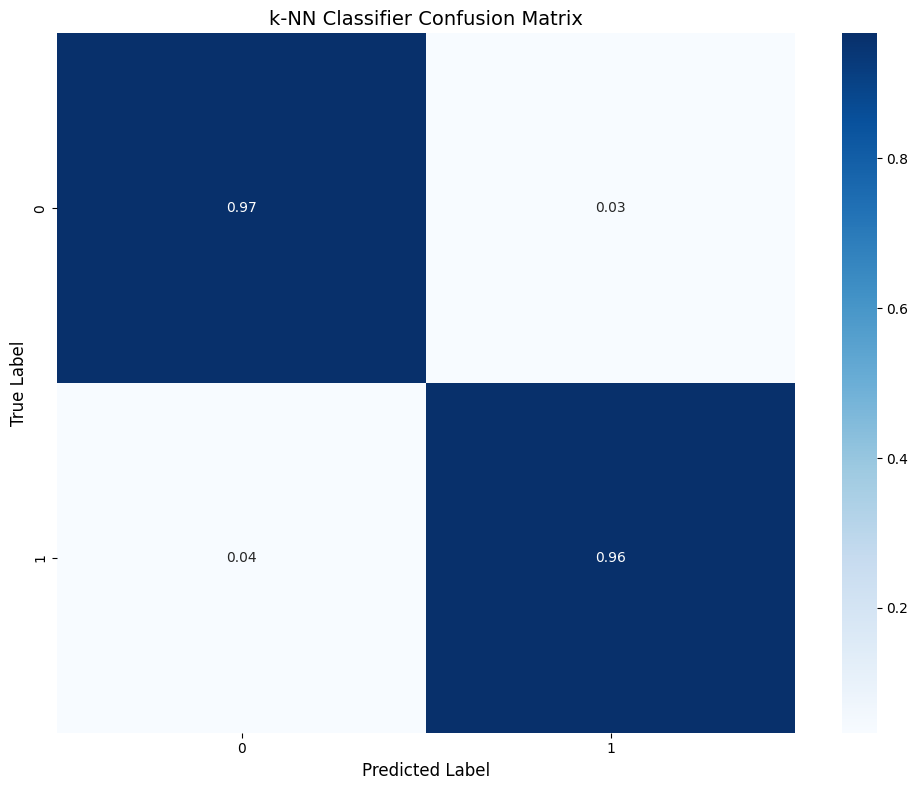

In [21]:
fig = evaluator.plot_confusion_matrix(
    test_labels, knn_preds_encoded,
    title="k-NN Classifier Confusion Matrix"
)
plt.show()

In [22]:
print("\nComparison: k-NN vs Practice_1_model")
print("-" * 40)
print(f"{'Metric':<20} {'k-NN':<12} {'Practice_1_model':<12}")
print("-" * 40)
print(f"{'Accuracy':<20} {knn_metrics['accuracy']:<12.4f} {practice_1_model_metrics['test_accuracy']:<12.4f}")
print(f"{'Macro F1':<20} {knn_metrics['macro_f1']:<12.4f} {practice_1_model_metrics['test_macro_f1']:<12.4f}")


Comparison: k-NN vs Practice_1_model
----------------------------------------
Metric               k-NN         Practice_1_model
----------------------------------------
Accuracy             0.9646       0.9640      
Macro F1             0.9646       0.9640      


---
## 4.3 Transformer + k-NN (RAG) <a id="43-hybrid"></a>


In [23]:


hybrid_classifier = HybridClassifier(
    teacher_model=practice_1_model.model,  # Cambiado de practice_1_model a practice_1_model.model
    tokenizer=practice_1_model.tokenizer,
    knn_classifier=knn_classifier,
    alpha=0.5,
    device=DEVICE
)

print("Hybrid Classifier initialized:")
print(f"  {hybrid_classifier.get_params()}")

Hybrid Classifier initialized:
  {'alpha': 0.5, 'k': 5, 'num_classes': 2, 'teacher_model': 'roberta-base'}


In [24]:
print("\n Alpha Experiment...")
alpha_values = [0.0, 0.25, 0.5, 0.75, 1.0]

alpha_results = hybrid_classifier.experiment_alpha_values(
    texts=test_texts,
    true_labels=test_labels,
    alpha_values=alpha_values
)

print("\n Results by Alpha:")
print("-" * 50)
print(f"{'Alpha':<10} {'Accuracy':<15} {'Macro F1':<15}")
print("-" * 50)
for alpha, metrics in alpha_results.items():
    print(f"{alpha:<10.2f} {metrics['accuracy']:<15.4f} {metrics['macro_f1']:<15.4f}")


 Alpha Experiment...

 Results by Alpha:
--------------------------------------------------
Alpha      Accuracy        Macro F1       
--------------------------------------------------
0.00       0.9646          0.9646         
0.25       0.9653          0.9653         
0.50       0.9657          0.9657         
0.75       0.9663          0.9663         
1.00       0.9658          0.9658         


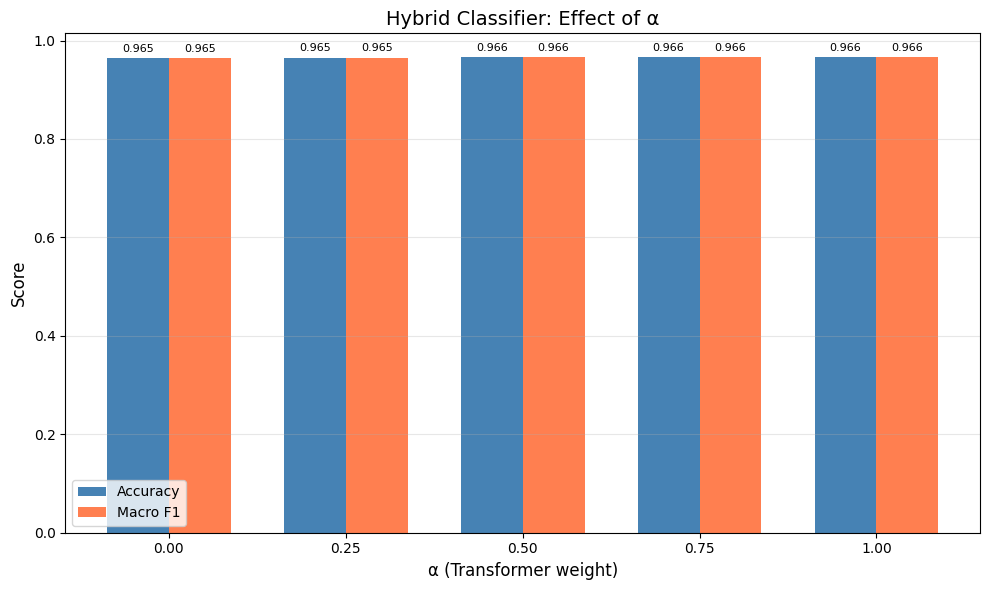

In [25]:
fig = evaluator.plot_alpha_experiment(alpha_results)
plt.show()

In [26]:
best_alpha = max(alpha_results.keys(), key=lambda a: alpha_results[a]['macro_f1'])
print(f"\n Best α = {best_alpha}")
print(f"   Accuracy: {alpha_results[best_alpha]['accuracy']:.4f}")
print(f"   Macro F1: {alpha_results[best_alpha]['macro_f1']:.4f}")

hybrid_classifier.set_alpha(best_alpha)


 Best α = 0.75
   Accuracy: 0.9663
   Macro F1: 0.9663


In [27]:
hybrid_preds, hybrid_details = hybrid_classifier.predict(
    test_texts, return_details=True
)

hybrid_preds_encoded = np.array([label_to_idx.get(p, 0) for p in hybrid_preds])
hybrid_metrics = evaluator.compute_metrics(test_labels, hybrid_preds_encoded)

print(f"\n Hybrid Classifier Metrics (α={best_alpha}):")
for metric, value in hybrid_metrics.items():
    print(f"  {metric}: {value:.4f}")


 Hybrid Classifier Metrics (α=0.75):
  accuracy: 0.9663
  macro_f1: 0.9663
  weighted_f1: 0.9663
  macro_precision: 0.9664
  macro_recall: 0.9663
  f1_0: 0.9665
  f1_1: 0.9662


---
## 4.4 Retrieval-Based Explainability <a id="44-explainability"></a>

Using retrieval to provide case-based explanations.

In [28]:
explainability = ExplainabilityModule(
    retriever=retriever,
    summarizer=None  
)

print("ExplainabilityModule initialized")

ExplainabilityModule initialized


In [29]:
selected = explainability.select_examples_for_analysis(
    texts=test_texts,
    predictions=hybrid_preds.tolist(),
    true_labels=test_labels_raw,
    num_correct=10,
    num_incorrect=10
)

print(f"Selected {len(selected['correct'])} correct examples")
print(f"Selected {len(selected['incorrect'])} incorrect examples")

Selected 10 correct examples
Selected 10 incorrect examples


In [30]:
print("\n" + "="*80)
print("CORRECTLY CLASSIFIED EXAMPLES")
print("="*80)

for idx in selected['correct'][:5]:
    result = explainability.explain_prediction(
        text=test_texts[idx],
        prediction=hybrid_preds[idx],
        k=5,
        true_label=test_labels_raw[idx],
        generate_summary=False
    )
    
    print(explainability.format_explanation_for_display(result, show_neighbors=3))


CORRECTLY CLASSIFIED EXAMPLES
Status: ✓ CORRECT

Text: Great Design A great designed T-shirt.When they release a new deisgn shirt like the cover of the album "Diary", I'm sure that I will get it again.Good quality,tough for washing machine.I really liked ...

Prediction: 1
True Label: 1

Similar Training Examples (3):
  [1] (1): Great item Another nice piece from the Mission Collection. I would buy more. We are using this in ou...
  [2] (1): Coleman Dining Kit I recently purchased this to use at home for outside and inside meals. We like th...
  [3] (1): Great case I've built three computers for family using this case and they all love it. A bit wider t...

Case-Based Explanation:
  Among the 5 most similar training examples, 5 labeled as '1'. Common terms include: 'it.', 'great', 'like', 'really'. The prediction '1' is supported by 5/5 similar examples.
Status: ✓ CORRECT

Text: Good Ink Source So far so good... this cartridge is still printing good, saturated, clean images after seve

In [31]:
print("\n" + "="*80)
print("INCORRECTLY CLASSIFIED EXAMPLES")
print("="*80)

for idx in selected['incorrect'][:5]:
    result = explainability.explain_prediction(
        text=test_texts[idx],
        prediction=hybrid_preds[idx],
        k=5,
        true_label=test_labels_raw[idx],
        generate_summary=False
    )
    
    print(explainability.format_explanation_for_display(result, show_neighbors=3))


INCORRECTLY CLASSIFIED EXAMPLES
Status: ✗ INCORRECT

Text: Stout wool, fine silk, and dressmaking...again. If you hate action and want to learn more about the cut of a dress, then this book is for you. After struggling with action, fighting, and a plot at the...

Prediction: 1
True Label: 0

Similar Training Examples (3):
  [1] (1): Old Clancy is Back I used to be one of those fans who bought his books the day they came out. Ever s...
  [2] (1): Suraj Barjatya is best in movies on marriage. And here he is; back to his basics on Vivaah. As the s...
  [3] (1): Salvage Dream With evry film, Carl Watts just keeps getting better and better. This is the best movi...

Case-Based Explanation:
  Among the 5 most similar training examples, 5 labeled as '1'. Common terms include: 'about', 'you.', 'can', 'want', 'good'. The prediction '1' is supported by 5/5 similar examples.
Status: ✗ INCORRECT

Text: To this day when you speak of the Japanese cinema, most folks won't talk about Rashomon, or the

---
## 4.5 Model Compression / Distillation <a id="45-compression"></a>

Training a smaller student model using knowledge distillation.

In [17]:
STUDENT_MODEL_NAME = "distilbert-base-uncased"
STUDENT_SAVE_PATH = "models/student_distilbert"

compressor = ModelCompressor(
    teacher_model=practice_1_model.model,
    student_model_name=STUDENT_MODEL_NAME,
    num_labels=num_labels,
    device=DEVICE
)

teacher_params = sum(p.numel() for p in practice_1_model.model.parameters())
student_params = sum(p.numel() for p in compressor.student_model.parameters())

print(f"Student parameters: {student_params:,}")
print(f"Compression ratio: {teacher_params / student_params:.2f}x")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Student parameters: 66,955,010
Compression ratio: 1.86x


In [ ]:
student_preprocessor = TextPreprocessor(
    model_name=STUDENT_MODEL_NAME,
    max_length=256
)

train_dataset_student = student_preprocessor.prepare_dataset(train_texts, train_labels)
val_dataset_student = student_preprocessor.prepare_dataset(val_texts, val_labels)
test_dataset_student = student_preprocessor.prepare_dataset(test_texts, test_labels)

print("Student datasets prepared")

In [ ]:
TRAIN_STUDENT = True 

if TRAIN_STUDENT:
    print("\nTraining Student with Knowledge Distillation...")
    student_model = compressor.distill(
        train_dataset=train_dataset_student,
        val_dataset=val_dataset_student,
        epochs=3,
        batch_size=16,
        temperature=2.0,
        alpha=0.5,
        save_path=STUDENT_SAVE_PATH
    )


🎓 Training Student with Knowledge Distillation...


NameError: name 'compressor' is not defined

In [ ]:
# Compare Teacher vs Student
print("\n📊 Comparing Teacher vs Student...")

comparison = compressor.compare_models(
    test_dataset=test_dataset_student,
    texts_for_timing=test_texts[:256],
    batch_size=32
)

print("\n" + "="*60)
print(f"{'Metric':<25} {'Teacher':<15} {'Student':<15}")
print("="*60)
print(f"{'Accuracy':<25} {comparison['teacher']['accuracy']:<15.4f} {comparison['student']['accuracy']:<15.4f}")
print(f"{'Macro F1':<25} {comparison['teacher']['macro_f1']:<15.4f} {comparison['student']['macro_f1']:<15.4f}")
print(f"{'Parameters (M)':<25} {comparison['teacher']['parameters']/1e6:<15.2f} {comparison['student']['parameters']/1e6:<15.2f}")
print(f"{'Size (MB)':<25} {comparison['teacher']['size_mb']:<15.2f} {comparison['student']['size_mb']:<15.2f}")
if 'inference_time' in comparison['teacher']:
    print(f"{'Inference Time (s)':<25} {comparison['teacher']['inference_time']:<15.2f} {comparison['student']['inference_time']:<15.2f}")
print("="*60)
print(f"\nCompression Ratio: {comparison['compression_ratio']:.2f}x")
print(f"Accuracy Drop: {comparison['accuracy_drop']:.4f}")
print(f"F1 Drop: {comparison['f1_drop']:.4f}")
if 'speedup' in comparison:
    print(f"Speedup: {comparison['speedup']:.2f}x")

In [ ]:
# Plot compression comparison
fig = evaluator.plot_compression_comparison(comparison)
plt.show()

---
## 4.6 Generador de Resumenes <a id="46-summarization"></a>

In [ ]:
summarizer = SummarizationExplainer(
    model_name="t5-small",
    device=DEVICE,
    max_input_length=512,
    max_output_length=150
)

print("SummarizationExplainer initialized with t5-small")

In [ ]:
print("\n Generating Global Class Summaries...")
print("="*80)

class_summaries = {}

for label in label_names:
    class_texts = [t for t, l in zip(train_texts, train_labels_raw) if l == label]
    
    summary = summarizer.generate_class_summary(
        texts=class_texts,
        class_name=label,
        num_samples=50
    )
    
    class_summaries[label] = summary
    
    print(f"\n Class: {label.upper()}")
    print(f"   (Based on {len(class_texts)} training examples)")
    print(f"   Summary: {summary}")
    print("-"*80)

In [ ]:
# Update ExplainabilityModule with summarizer
explainability = ExplainabilityModule(
    retriever=retriever,
    summarizer=summarizer
)

print("ExplainabilityModule updated with SummarizationExplainer")

In [ ]:
print("\n Generating Local Explanations with LLM...")
print("="*80)

detailed_correct = selected['correct'][:3]
detailed_incorrect = selected['incorrect'][:3]

for name, indices in [("CORRECT", detailed_correct), ("INCORRECT", detailed_incorrect)]:
    print(f"\n{'='*80}")
    print(f" {name} PREDICTIONS" if name == "CORRECT" else f" {name} PREDICTIONS")
    print(f"{'='*80}")
    
    for idx in indices:
        result = explainability.explain_prediction(
            text=test_texts[idx],
            prediction=hybrid_preds[idx],
            k=5,
            true_label=test_labels_raw[idx],
            generate_summary=True
        )
        
        print(explainability.format_explanation_for_display(result, show_neighbors=3))

In [ ]:
print("\n Hallucination Analysis:")

for idx in detailed_correct[:2]:
    results = retriever.search([test_texts[idx]], k=5)
    neighbors = results[0]
    
    neighbor_dicts = [
        {"text": t, "label": l}
        for t, l in zip(neighbors.texts, neighbors.labels)
    ]
    
    explanation = summarizer.generate_local_explanation(
        test_texts[idx], neighbor_dicts, str(hybrid_preds[idx])
    )
    
    analysis = summarizer.analyze_hallucinations(
        explanation,
        [test_texts[idx]] + neighbors.texts
    )
    
    print(f"\nExample {idx}:")
    print(f"  Novel words: {analysis['novel_word_count']}")
    print(f"  Source coverage: {analysis['source_coverage']:.2%}")
    print(f"  Warning: {analysis['warning']}")
    if analysis['novel_words']:
        print(f"  Examples: {analysis['novel_words'][:5]}")

---
## 4.7 Global Analysis & Discussion <a id="47-analysis"></a>

Comprehensive comparison of all methods.

In [ ]:
all_results = {
    "Teacher (RoBERTa)": {
        "accuracy": practice_1_model_metrics['test_accuracy'],
        "macro_f1": practice_1_model_metrics['test_macro_f1'],
        "parameters": comparison['teacher']['parameters'],
    },
    "k-NN (k=5)": {
        "accuracy": knn_metrics['accuracy'],
        "macro_f1": knn_metrics['macro_f1'],
        "parameters": 0,
    },
    f"Hybrid (α={best_alpha})": {
        "accuracy": hybrid_metrics['accuracy'],
        "macro_f1": hybrid_metrics['macro_f1'],
        "parameters": comparison['teacher']['parameters'],  # Uses teacher
    },
    "Student (DistilBERT)": {
        "accuracy": comparison['student']['accuracy'],
        "macro_f1": comparison['student']['macro_f1'],
        "parameters": comparison['student']['parameters'],
    },
}

comparison_df = evaluator.generate_comparison_table(
    all_results,
    metrics=['accuracy', 'macro_f1']
)

print("\n FINAL MODEL COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

In [ ]:
fig = evaluator.plot_model_comparison(
    all_results,
    metrics=['accuracy', 'macro_f1'],
    title="Model Comparison: All Methods"
)
plt.show()

In [ ]:
print("\n Per-Class F1 Comparison:")
print("="*70)

from sklearn.metrics import f1_score

per_class_comparison = {}

for label_idx, label in enumerate(label_names):
    teacher_f1 = f1_score(
        [1 if l == label_idx else 0 for l in test_labels],
        [1 if l == label_idx else 0 for l in teacher_preds],
        zero_division=0
    )
    
    knn_f1 = f1_score(
        [1 if l == label_idx else 0 for l in test_labels],
        [1 if l == label_idx else 0 for l in knn_preds_encoded],
        zero_division=0
    )
    
    hybrid_f1 = f1_score(
        [1 if l == label_idx else 0 for l in test_labels],
        [1 if l == label_idx else 0 for l in hybrid_preds_encoded],
        zero_division=0
    )
    
    per_class_comparison[label] = {
        'Teacher': teacher_f1,
        'k-NN': knn_f1,
        'Hybrid': hybrid_f1
    }

per_class_df = pd.DataFrame(per_class_comparison).T
print(per_class_df.round(4).to_string())

### 📝 Discussion Points

Based on the experiments above, address:

1. **Quality vs Cost Trade-off**:
   - Which combination offers the best balance?
   - Is the compression worth the quality drop?

2. **Bias & Fairness**:
   - Are some classes systematically worse with smaller models?
   - Could retrieval amplify biases?

3. **Explainability Methods**:
   - Token-based (P1) vs Example-based (retrieval) vs Generative (summarization)
   - Pros and cons of each approach

4. **Risks**:
   - Hallucinations in generated explanations
   - Using compressed models without re-evaluating biases

In [ ]:
import json
EXPERIMENTS_RESULTS_PATH = 'models/experiment_results/results.json'

final_results = {
    "model_comparison": all_results,
    "retrieval_metrics": retrieval_metrics,
    "alpha_experiment": {str(k): v for k, v in alpha_results.items()},
    "compression_comparison": {
        "compression_ratio": comparison['compression_ratio'],
        "accuracy_drop": comparison['accuracy_drop'],
        "f1_drop": comparison['f1_drop'],
        "speedup": comparison.get('speedup', 1.0)
    },
    "class_summaries": class_summaries
}

def convert_to_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(i) for i in obj]
    return obj

final_results = convert_to_serializable(final_results)

with open(EXPERIMENTS_RESULTS_PATH, 'w') as f:
    json.dump(final_results, f, indent=2)


print(" Results saved to models/experiment_results.json")